### In this project we will be using a Dataset consisting of data related to the tweets from 24th July 2020 to 30th August 2020. We will be using python to apply sentimental analysis on the tweets to see people reactions to the pandemic during the mentioned period. We will be labelling the tweets as Positive, Negative and neutral. We will then visualize the result to see people reactions on twitter.   

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re
import string
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

# Modules for visualizations
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import plotly.express as px


sns.set(style="darkgrid")


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/chinmayee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/chinmayee/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/chinmayee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Importing the dataset
https://raw.githubusercontent.com/gabrielpreda/covid-19-tweets/master/covid19_tweets.csv

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/gabrielpreda/covid-19-tweets/master/covid19_tweets.csv")

In [3]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [4]:
df.shape

(179108, 13)

There are 13 columns, so we will select only the needed coloumns for the project

In [5]:
needed_col = ['user_name','date','text']
df = df[needed_col]
df.head()

,user_name,date,text
0,ᏉᎥ☻լꂅϮ,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...
1,Tom Basile 🇺🇸,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2,Time4fisticuffs,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...
3,ethel mertz,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...
4,DIPR-J&K,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...


## Changing the type of some columns

In [6]:
# changinf the type of user_name to allocate it some numeric values instead
df.user_name = df.user_name.astype('category')
df.user_name = df.user_name.cat.codes

# changing the date-time column to only date 
df.date = pd.to_datetime(df.date).dt.date
df.head()

,user_name,date,text
0,89755,2020-07-25,If I smelled the scent of hand sanitizers toda...
1,76403,2020-07-25,Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2,76147,2020-07-25,@diane3443 @wdunlap @realDonaldTrump Trump nev...
3,84572,2020-07-25,@brookbanktv The one gift #COVID19 has give me...
4,18398,2020-07-25,25 July : Media Bulletin on Novel #CoronaVirus...


## Picking out the tweet texts

In [24]:
texts = df.text
texts

0         If I smelled the scent of hand sanitizers toda...
1         Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2         @diane3443 @wdunlap @realDonaldTrump Trump nev...
3         @brookbanktv The one gift #COVID19 has give me...
4         25 July : Media Bulletin on Novel #CoronaVirus...
                                ...                        
179103    Thanks @IamOhmai for nominating me for the @WH...
179104    2020! The year of insanity! Lol! #COVID19 http...
179105    @CTVNews A powerful painting by Juan Lucena. I...
179106    More than 1,200 students test positive for #CO...
179107    I stop when I see a Stop\n\n@SABCNews\n@Izinda...
Name: text, Length: 179108, dtype: object

## Removing URLs from the tweets (substtute urls with null)

In [25]:
remove_urls = lambda x: re.sub(r'https\S','',str(x))
#applying the above to all the tweets
text_url = texts.apply(remove_urls)
text_url

0         If I smelled the scent of hand sanitizers toda...
1         Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2         @diane3443 @wdunlap @realDonaldTrump Trump nev...
3         @brookbanktv The one gift #COVID19 has give me...
4         25 July : Media Bulletin on Novel #CoronaVirus...
                                ...                        
179103    Thanks @IamOhmai for nominating me for the @WH...
179104    2020! The year of insanity! Lol! #COVID19 //t....
179105    @CTVNews A powerful painting by Juan Lucena. I...
179106    More than 1,200 students test positive for #CO...
179107    I stop when I see a Stop\n\n@SABCNews\n@Izinda...
Name: text, Length: 179108, dtype: object

## Converting texts to lower cases

In [26]:
tolower = lambda x: x.lower()
text_url_lc = texts.apply(tolower)
text_url_lc

0         if i smelled the scent of hand sanitizers toda...
1         hey @yankees @yankeespr and @mlb - wouldn't it...
2         @diane3443 @wdunlap @realdonaldtrump trump nev...
3         @brookbanktv the one gift #covid19 has give me...
4         25 july : media bulletin on novel #coronavirus...
                                ...                        
179103    thanks @iamohmai for nominating me for the @wh...
179104    2020! the year of insanity! lol! #covid19 http...
179105    @ctvnews a powerful painting by juan lucena. i...
179106    more than 1,200 students test positive for #co...
179107    i stop when i see a stop\n\n@sabcnews\n@izinda...
Name: text, Length: 179108, dtype: object

## Removing punctuation from the texts

In [33]:
# function to map each character with the corresponding character in the translation table
# maketrans() - to create a translation table where everthing remains same but only punctuations are removed
remove_punc = lambda x: x.translate(str.maketrans('','',string.punctuation))
text_url_lc_pu = text_url_lc.apply(remove_punc)
text_url_lc_pu

0         if i smelled the scent of hand sanitizers toda...
1         hey yankees yankeespr and mlb  wouldnt it have...
2         diane3443 wdunlap realdonaldtrump trump never ...
3         brookbanktv the one gift covid19 has give me i...
4         25 july  media bulletin on novel coronavirusup...
                                ...                        
179103    thanks iamohmai for nominating me for the who ...
179104    2020 the year of insanity lol covid19 httpstco...
179105    ctvnews a powerful painting by juan lucena its...
179106    more than 1200 students test positive for covi...
179107    i stop when i see a stop\n\nsabcnews\nizindaba...
Name: text, Length: 179108, dtype: object

### Removing stopwords

In [34]:
# updating the stopwords list with covid's common words
more_stops = ['covid','#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19']
stop_words = set(stopwords.words('english'))
stop_words.update(more_stops)

#removng stopwords from the text
remove_stops = lambda x: ' '.join([word for word in x.split() if word not in stop_words])
text_url_lc_pu_sw = text_url_lc_pu.apply(remove_stops)
text_url_lc_pu_sw

0         smelled scent hand sanitizers today someone pa...
1         hey yankees yankeespr mlb wouldnt made sense p...
2         diane3443 wdunlap realdonaldtrump trump never ...
3         brookbanktv one gift give appreciation simple ...
4         25 july media bulletin novel coronavirusupdate...
                                ...                        
179103    thanks iamohmai nominating wearamask challenge...
179104            2020 year insanity lol httpstcoy48np0yzgn
179105    ctvnews powerful painting juan lucena tribute ...
179106    1200 students test positive major university a...
179107    stop see stop sabcnews izindabanews24 dailysun...
Name: text, Length: 179108, dtype: object

These are all of the words commonly used in English which might not help us in the analysis

## Creating a big dataset of words out of all the tweets


In [47]:
words_list = [word for line in text_url_lc_pu_sw for word in line.split()]
word_counter = Counter(words_list).most_common(50)
word_df = pd.DataFrame(word_counter)  # converting into dataframe
word_df.columns = ["Word","Frequency"]  #Giving Column names

#plotting the data in a bar chart
px.bar(word_df,x="Word",y="Frequency",title="Most common words")

In [48]:
df.head()

,user_name,date,text
0,89755,2020-07-25,If I smelled the scent of hand sanitizers toda...
1,76403,2020-07-25,Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2,76147,2020-07-25,@diane3443 @wdunlap @realDonaldTrump Trump nev...
3,84572,2020-07-25,@brookbanktv The one gift #COVID19 has give me...
4,18398,2020-07-25,25 July : Media Bulletin on Novel #CoronaVirus...


The main dataframe needs to be updates with the new cleaned data.

In [49]:
df.text = text_url_lc_pu_sw
df.head()

,user_name,date,text
0,89755,2020-07-25,smelled scent hand sanitizers today someone pa...
1,76403,2020-07-25,hey yankees yankeespr mlb wouldnt made sense p...
2,76147,2020-07-25,diane3443 wdunlap realdonaldtrump trump never ...
3,84572,2020-07-25,brookbanktv one gift give appreciation simple ...
4,18398,2020-07-25,25 july media bulletin novel coronavirusupdate...


## Sentiments analysis

In [83]:
sid = SentimentIntensityAnalyzer()
ps = lambda x: sid.polarity_scores(x)  #calculates polarity scores for each of the texts
sentiment_scores = df.text.apply(ps)
sentiment_df = pd.DataFrame(data = list(sentiment_scores))
sentiment_df.head()

,neg,neu,pos,compound
0,0.000,0.775,0.225,0.4939
1,0.102,0.730,0.168,0.2263
2,0.000,0.846,0.154,0.2057
3,0.000,0.592,0.408,0.7351
4,0.000,0.813,0.187,0.3182


## Labelling the score based on compound polarity value

In [84]:
labelize = lambda x: 'neutral' if x == 0 else ('positive' if x>0 else 'negative')
sentiment_df['label'] = sentiment_df.compound.apply(labelize)
sentiment_df.tail()

,neg,neu,pos,compound,label
179103,0.000,0.625,0.375,0.4939,positive
179104,0.389,0.316,0.295,-0.2263,negative
179105,0.234,0.584,0.182,-0.2023,negative
179106,0.000,0.690,0.310,0.5574,positive
179107,0.328,0.672,0.000,-0.5267,negative


In [85]:
df.head()

,user_name,date,text
0,89755,2020-07-25,smelled scent hand sanitizers today someone pa...
1,76403,2020-07-25,hey yankees yankeespr mlb wouldnt made sense p...
2,76147,2020-07-25,diane3443 wdunlap realdonaldtrump trump never ...
3,84572,2020-07-25,brookbanktv one gift give appreciation simple ...
4,18398,2020-07-25,25 july media bulletin novel coronavirusupdate...


The main dataframe needs to be updated with the new 'Label' column 
#### Hence joining both the dataframes

In [64]:
new_df = df.join(sentiment_df.label)
new_df.head()

,user_name,date,text,label
0,89755,2020-07-25,smelled scent hand sanitizers today someone pa...,positive
1,76403,2020-07-25,hey yankees yankeespr mlb wouldnt made sense p...,positive
2,76147,2020-07-25,diane3443 wdunlap realdonaldtrump trump never ...,positive
3,84572,2020-07-25,brookbanktv one gift give appreciation simple ...,positive
4,18398,2020-07-25,25 july media bulletin novel coronavirusupdate...,positive


## Plotting the sentiment score counts
(How many positive, negativem, neutral?)

In [86]:
counts_df = new_df.label.value_counts().reset_index()
counts_df

,index,label
0,positive,70049
1,neutral,62522
2,negative,46537


<AxesSubplot:xlabel='index', ylabel='label'>

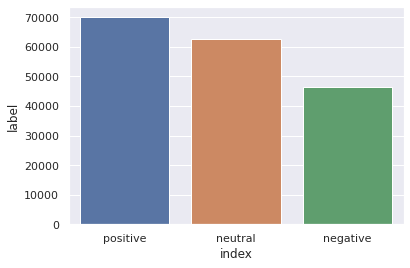

In [87]:
sns.barplot(x = 'index', y = 'label',data = counts_df)

Most of the tweets in the durationn of 26.06.20 to 30.06.20, were Positive > Neutral > Negative

### To count how many positve, negative, neutral tweets were there on a particular date

In [91]:

new_df_aggr = new_df[['user_name','date','label']].groupby(['date','label']).count().reset_index()
new_df_aggr.columns = ['date','label','users']
new_df_aggr.head()

,date,label,users
0,2020-07-24,negative,84
1,2020-07-24,neutral,96
2,2020-07-24,positive,115
3,2020-07-25,negative,4324
4,2020-07-25,neutral,5799


Plotting the above in a line graph

In [94]:
px.line(new_df_aggr,x = 'date',y = 'users', color = 'label',title ='Daily Tweets Sentimental Analysis')


Here, we visualized how the positive,negative and neutral tweets changed everyday from Jul 26th to Aug 30th.